In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import random
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D

In [110]:
def logistic_regression(X, y):
    try:
        model_fit = sm.Logit(y,X).fit(maxiter=50)
        return model_fit.prsquared
    except np.linalg.LinAlgError:
        return 0
    except sm.tools.sm_exceptions.PerfectSeparationError:
        return 1 # Data is linearly separable
    
def linear_regression(x, y):    
    X = np.transpose([np.ones(len(x)), x])
    model_fit = sm.OLS(y, X).fit()
    return (model_fit.rsquared, model_fit.params[1], model_fit.params[0])

def sample_trials(alevel_idxs, n_samples):
    trial_per_alevel = 500
    trials_offset = 200 # Only consider the second half of the alevel
    
    trials_to_sample = []
    for n_bin in alevel_idxs:
        trial_s = n_bin * trial_per_alevel + trials_offset
        trial_t = (n_bin + 1) * trial_per_alevel
        trials_to_sample = trials_to_sample + list(range(trial_s, trial_t))
    return np.array(random.sample(trials_to_sample, n_samples))

In [154]:
def debug_plot(fr, v1, r, V_coeff, V_const):
    [fr_match_cue1, fr_match_cue2, fr_nonmatch_cue1, fr_nonmatch_cue2] = fr
    [v1_match_cue1, v1_match_cue2, v1_nonmatch_cue1, v1_nonmatch_cue2] = v1
    [r_match_cue1, r_match_cue2, r_nonmatch_cue1, r_nonmatch_cue2] = r
    
    plt.figure(figsize=(25,10))

    w = 0.3
    x = np.arange(4)

    axp = plt.subplot(2,4,2)
    plt.xticks(x, ["match/cue1", "match/cue2", "nonmatch/cue1", "nonmatch/cue2"])
    axp.bar(x,  np.nan_to_num([r_match_cue1, r_match_cue2, r_nonmatch_cue1, r_nonmatch_cue2]))
    axp.set_ylim((-1,1))
    axp.set_title("Pearson correleation r")

    ax2 = plt.subplot(2,4,5)
    ax2.scatter(fr_match_cue1, v1_match_cue1, marker=".")
    ax2.plot(x, V_coeff[0]*x + V_const[0])
    ax2.set_xlim((0,1))
    ax2.set_ylim((0,1))
    ax2.set_title("match/cue1")
    ax2.set_xlabel("neuron firing rate")
    ax2.set_ylabel("V1 value")
    
    ax3 = plt.subplot(2,4,6)
    ax3.scatter(fr_match_cue2, v1_match_cue2, marker=".")
    ax3.plot(x, V_coeff[1]*x + V_const[1])
    ax3.set_xlim((0,1))
    ax3.set_ylim((0,1))
    ax3.set_title("match/cue2")

    ax4 = plt.subplot(2,4,7)
    ax4.scatter(fr_nonmatch_cue1, v1_nonmatch_cue1, marker=".")
    ax4.plot(x, V_coeff[2]*x + V_const[2])
    ax4.set_xlim((0,1))
    ax4.set_ylim((0,1))
    ax4.set_title("non-match/cue1")

    print(len(fr_nonmatch_cue2), len(v1_nonmatch_cue2))
    ax5 = plt.subplot(2,4,8)
    ax5.scatter(fr_nonmatch_cue2, v1_nonmatch_cue2, marker=".")    
    ax5.plot(x, V_coeff[3]*x + V_const[3])
    ax5.set_xlim((0,1))
    ax5.set_ylim((0,1))
    ax5.set_title("non-match/cue2")
    
    return plt

def debug_plot_scatter(neuron_idx, rPFC_trials, rMD_trials, v1v2_values, cue, trials):
    CUE_TIME = 100
    cuetime_s = math.floor(CUE_TIME - (CUE_TIME / 2))
    cuetime_t = CUE_TIME
    
    neuron_all_cue = np.mean(rPFC_trials[:, cuetime_s:cuetime_t, neuron_idx],1)
    v1_all = v1v2_values[0,:]

    b_cue1 = cue.astype(bool)
    b_MD1_cue = np.rint(np.mean(rMD_trials[trials, cuetime_s:cuetime_t, 1], 1)).astype(bool)
    
    plt.figure(figsize=(14,7))
    
    ax1 = plt.subplot(1,2,1)
    
    trials_90_cue1_MD1 = np.array(trials[0:100])[b_cue1[0:100] * b_MD1_cue[0:100]]
    trials_90_cue1_MD0 = np.array(trials[0:100])[b_cue1[0:100] * np.invert(b_MD1_cue[0:100])]
    ax1.scatter(neuron_all_cue[trials_90_cue1_MD1], v1_all[trials_90_cue1_MD1], color='b', marker="^", alpha=0.5, s=80, label=".9")
    ax1.scatter(neuron_all_cue[trials_90_cue1_MD0], v1_all[trials_90_cue1_MD0], color='b', marker="^", alpha=0.5, s=80, linewidths=2, edgecolors='k')

    trials_90_cue0_MD1 = np.array(trials[0:100])[np.invert(b_cue1[0:100]) * b_MD1_cue[0:100]]
    trials_90_cue0_MD0 = np.array(trials[0:100])[np.invert(b_cue1[0:100]) * np.invert(b_MD1_cue[0:100])]
    ax1.scatter(neuron_all_cue[trials_90_cue0_MD1], v1_all[trials_90_cue0_MD1], color='b', marker="<", alpha=0.5, s=80)
    ax1.scatter(neuron_all_cue[trials_90_cue0_MD0], v1_all[trials_90_cue0_MD0], color='b', marker="<", alpha=0.5, s=80, linewidths=2, edgecolors='k')

    trials_10_cue1_MD1 = np.array(trials[200:300])[b_cue1[200:300] * b_MD1_cue[200:300]]
    trials_10_cue1_MD0 = np.array(trials[200:300])[b_cue1[200:300] * np.invert(b_MD1_cue[200:300])]
    ax1.scatter(neuron_all_cue[trials_10_cue1_MD1], v1_all[trials_10_cue1_MD1], color='g', marker="^", alpha=0.5, s=80, label=".1")
    ax1.scatter(neuron_all_cue[trials_10_cue1_MD0], v1_all[trials_10_cue1_MD0], color='g', marker="^", alpha=0.5, s=80, linewidths=2, edgecolors='k')

    trials_10_cue0_MD1 = np.array(trials[200:300])[np.invert(b_cue1[200:300]) * b_MD1_cue[200:300]]
    trials_10_cue0_MD0 = np.array(trials[200:300])[np.invert(b_cue1[200:300]) * np.invert(b_MD1_cue[200:300])]
    ax1.scatter(neuron_all_cue[trials_10_cue0_MD1], v1_all[trials_10_cue0_MD1], color='g', marker="<", alpha=0.5, s=80)
    ax1.scatter(neuron_all_cue[trials_10_cue0_MD0], v1_all[trials_10_cue0_MD0], color='g', marker="<", alpha=0.5, s=80, linewidths=2, edgecolors='k')

    trials_70_cue1_MD1 = np.array(trials[100:200])[b_cue1[100:200] * b_MD1_cue[100:200]]
    trials_70_cue1_MD0 = np.array(trials[100:200])[b_cue1[100:200] * np.invert(b_MD1_cue[100:200])]
    ax1.scatter(neuron_all_cue[trials_70_cue1_MD1], v1_all[trials_70_cue1_MD1], color='r', marker="^", alpha=0.5, s=80, label=".7")
    ax1.scatter(neuron_all_cue[trials_70_cue1_MD0], v1_all[trials_70_cue1_MD0], color='r', marker="^", alpha=0.5, s=80, linewidths=2, edgecolors='k')

    trials_70_cue0_MD1 = np.array(trials[100:200])[np.invert(b_cue1[100:200]) * b_MD1_cue[100:200]]
    trials_70_cue0_MD0 = np.array(trials[100:200])[np.invert(b_cue1[100:200]) * np.invert(b_MD1_cue[100:200])]
    ax1.scatter(neuron_all_cue[trials_70_cue0_MD1], v1_all[trials_70_cue0_MD1], color='r', marker="<", alpha=0.5, s=80)
    ax1.scatter(neuron_all_cue[trials_70_cue0_MD0], v1_all[trials_70_cue0_MD0], color='r', marker="<", alpha=0.5, s=80, linewidths=2, edgecolors='k')

    trials_30_cue1_MD1 = np.array(trials[300:400])[b_cue1[300:400] * b_MD1_cue[300:400]]
    trials_30_cue1_MD0 = np.array(trials[300:400])[b_cue1[300:400] * np.invert(b_MD1_cue[300:400])]
    ax1.scatter(neuron_all_cue[trials_30_cue1_MD1], v1_all[trials_30_cue1_MD1], color='c', marker="^", alpha=0.5, s=80, label=".3")
    ax1.scatter(neuron_all_cue[trials_30_cue1_MD0], v1_all[trials_30_cue1_MD0], color='c', marker="^", alpha=0.5, s=80, linewidths=2, edgecolors='k')

    trials_30_cue0_MD1 = np.array(trials[300:400])[np.invert(b_cue1[300:400]) * b_MD1_cue[300:400]]
    trials_30_cue0_MD0 = np.array(trials[300:400])[np.invert(b_cue1[300:400]) * np.invert(b_MD1_cue[300:400])]
    ax1.scatter(neuron_all_cue[trials_30_cue0_MD1], v1_all[trials_30_cue0_MD1], color='r', marker="<", alpha=0.5, s=80)
    ax1.scatter(neuron_all_cue[trials_30_cue0_MD0], v1_all[trials_30_cue0_MD0], color='r', marker="<", alpha=0.5, s=80, linewidths=2, edgecolors='k')

    ax1.set_xlabel('PFC activity')
    ax1.set_ylabel('V1 value')
    ax1.legend()
    
    return plt

In [175]:
def get_data(data_dir):
    N_PFC_NEURONS = 500
    N_MD_NEURONS = 2
    N_OUTPUT_NEURONS = 2
    TRIAL_TIME = 200

    s_trial = 0
    t_trial = 4500
    n_trials = t_trial - s_trial

    rPFC_trials = np.zeros((n_trials, TRIAL_TIME, N_PFC_NEURONS))
    rMD_trials = np.zeros((n_trials, TRIAL_TIME, N_MD_NEURONS))
    task_input = np.zeros((2, n_trials))
    v1v2_values = np.zeros((2, n_trials))

    for i in range(s_trial, t_trial):
        with open(data_dir + "/" + str(i) + ".json") as json_file:
            data = json.load(json_file)
            idx = i - s_trial

            rPFC = np.array(data["network_rates"]["r_PFC"])
            rPFC_trials[idx,:,:] = rPFC
            
            rMD = np.array(data["network_rates"]["r_MD"])
            rMD_trials[idx,:,:] = rMD

            trial_task_input = np.array(data["trial_data"]["input"])
            task_input[:,idx] = trial_task_input[:2]
            v1v2_values[:,idx] = trial_task_input[2:4]
            
    return (rPFC_trials, rMD_trials, task_input, v1v2_values)
            
def score_uniqueness(rPFC_trials, task_input, v1v2_values):
    N_PFC_NEURONS = 500
    N_MD_NEURONS = 2
    N_OUTPUT_NEURONS = 2
    TRIAL_TIME = 200
    
    CUE_TIME = 100
    TRIAL_SAMPLE_SIZE = 150
    
    # Block schedule ['30', '90', '10', '90', '70', '30', '10', '70']
    alevel_90_idxs = [1,3]
    alevel_10_idxs = [2,6]
    alevel_70_idxs = [4,7]
    alevel_30_idxs = [0,5]

    pearson_R = np.zeros((N_PFC_NEURONS, 4))

    # Randomly sample trials for analysis from the second half of each alevel
    # We ensure all alevels are equally represented

    alevel_90_trials = sample_trials(alevel_90_idxs, TRIAL_SAMPLE_SIZE)
    alevel_10_trials = sample_trials(alevel_10_idxs, TRIAL_SAMPLE_SIZE)
    alevel_70_trials = sample_trials(alevel_70_idxs, TRIAL_SAMPLE_SIZE)
    alevel_30_trials = sample_trials(alevel_30_idxs, TRIAL_SAMPLE_SIZE)
    
    match_trials = np.concatenate((alevel_90_trials, alevel_70_trials))
    nonmatch_trials = np.concatenate((alevel_10_trials, alevel_30_trials))
    trials = np.concatenate((match_trials, nonmatch_trials))

    # Plot distribution of association levels
#     plt.hist(v1v2_values[0,trials])
#     plt.xlabel("V1 Value")
#     plt.ylabel("Num trials")
#     plt.show()

    match_trials_idxs = v1v2_values[0,match_trials] >= 0.6
    nonmatch_trials_idxs = v1v2_values[0,nonmatch_trials] <= 0.4
    match_trials = match_trials[match_trials_idxs]
    nonmatch_trials = nonmatch_trials[nonmatch_trials_idxs]
    trials = np.concatenate((match_trials, nonmatch_trials))

    # Get cue 1 value and neuron activity for each trial
    # Only consider the activity over the second half of the cue period

    cuetime_s = math.floor(CUE_TIME - (CUE_TIME / 2))
    cuetime_t = CUE_TIME

    trials_match_cue1 = match_trials[np.where(task_input[0,match_trials])]
    trials_match_cue2 = match_trials[np.where(1-task_input[0,match_trials])]
    trials_nonmatch_cue1 = nonmatch_trials[np.where(task_input[0,nonmatch_trials])]
    trials_nonmatch_cue2 = nonmatch_trials[np.where(1-task_input[0,nonmatch_trials])]

    v1_match_cue1 = v1v2_values[0,trials_match_cue1]
    v1_match_cue2 = v1v2_values[0,trials_match_cue2]
    v1_nonmatch_cue1 = v1v2_values[0,trials_nonmatch_cue1]
    v1_nonmatch_cue2 = v1v2_values[0,trials_nonmatch_cue2]
    
    V_coeff = np.zeros((N_PFC_NEURONS, 4))
    V_const = np.zeros((N_PFC_NEURONS, 4))

    # Compute regression and plot

    for neuron_idx in range(N_PFC_NEURONS):
        fr_match_cue1 = np.mean(rPFC_trials[trials_match_cue1, cuetime_s:cuetime_t, neuron_idx],1)
        fr_match_cue2 = np.mean(rPFC_trials[trials_match_cue2, cuetime_s:cuetime_t, neuron_idx],1)
        fr_nonmatch_cue1 = np.mean(rPFC_trials[trials_nonmatch_cue1, cuetime_s:cuetime_t, neuron_idx],1)
        fr_nonmatch_cue2 = np.mean(rPFC_trials[trials_nonmatch_cue2, cuetime_s:cuetime_t, neuron_idx],1)
        
        (r2_match_cue1, coeff_match_cue1, const_match_cue1) = linear_regression(fr_match_cue1, v1_match_cue1)
        (r2_match_cue2, coeff_match_cue2, const_match_cue2) = linear_regression(fr_match_cue2, v1_match_cue2)
        (r2_nonmatch_cue1, coeff_nonmatch_cue1, const_nonmatch_cue1) = linear_regression(fr_nonmatch_cue1, v1_nonmatch_cue1)
        (r2_nonmatch_cue2, coeff_nonmatch_cue2, const_nonmatch_cue2) = linear_regression(fr_nonmatch_cue2, v1_nonmatch_cue2)
        V_coeff[neuron_idx,:] = [coeff_match_cue1, coeff_match_cue2, coeff_nonmatch_cue1, coeff_nonmatch_cue2]
        V_const[neuron_idx,:] = [const_match_cue1, const_match_cue2, const_nonmatch_cue1, const_nonmatch_cue2]

        [r_match_cue1, p_match_cue1] = stats.pearsonr(fr_match_cue1, v1_match_cue1)
        [r_match_cue2, p_match_cue2] = stats.pearsonr(fr_match_cue2, v1_match_cue2)
        [r_nonmatch_cue1, p_nonmatch_cue1] = stats.pearsonr(fr_nonmatch_cue1, v1_nonmatch_cue1)    
        [r_nonmatch_cue2, p_nonmatch_cue2] = stats.pearsonr(fr_nonmatch_cue2, v1_nonmatch_cue2)
        pearson_R[neuron_idx,:] = [r_match_cue1, r_match_cue2, r_nonmatch_cue1, r_nonmatch_cue2]
        
        
        # Plots for debuggin (NOTE: First plot is broken)
#         plt1 = debug_plot_scatter(neuron_idx, rPFC_trials, rMD_trials, v1v2_values, task_input[0, trials].astype(bool), trials)
#         plt1.show()
#         fr = [fr_match_cue1, fr_match_cue2, fr_nonmatch_cue1, fr_nonmatch_cue2]
#         v1 = [v1_match_cue1, v1_match_cue2, v1_nonmatch_cue1, v1_nonmatch_cue2]
#         r = [r_match_cue1, r_match_cue2, r_nonmatch_cue1, r_nonmatch_cue2]        
#         plt2 = debug_plot(fr, v1, r, V_coeff[neuron_idx,:], V_const[neuron_idx,:])
#         plt2.show()
        
    scores = np.zeros((pearson_R.shape[0],1))
    for i in range(0,pearson_R.shape[0]):
        r_vals = np.nan_to_num(np.abs(pearson_R[i,:]))
        max_r = max(r_vals)
        others = np.delete(r_vals, np.where(r_vals == max(r_vals))[0][0])
        scores[i] = max_r - sum(others)  
        
    return scores

In [161]:
# (rPFC_trials, rMD_trials, task_input, v1v2_values) = get_data("/om2/group/halassa/PFCMD-ali-sabrina/MD_on/by_trial")
(rPFC_trials_noMD, rMD_trials, task_input_noMD, v1v2_values_noMD) = get_data("/om2/group/halassa/PFCMD-ali-sabrina/MD_off/by_trial")

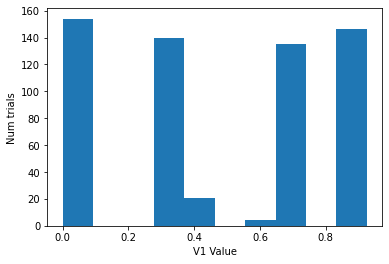

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


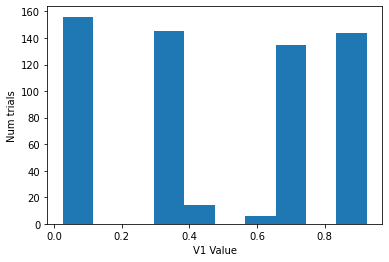

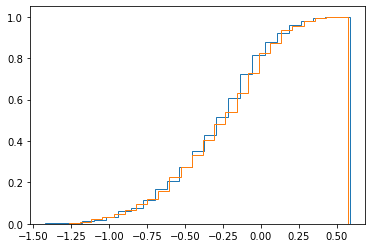

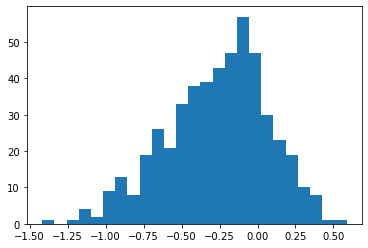

In [176]:
scores = score_uniqueness(rPFC_trials, task_input, v1v2_values)
scores_noMD = score_uniqueness(rPFC_trials, task_input, v1v2_values)
plt.hist(scores, bins=25, density=True, cumulative=True, histtype='step')
plt.hist(scores_noMD, bins=25, density=True, cumulative=True, histtype='step')
plt.show()

plt.hist(scores, bins=25)
plt.show()

# plt.hist(scores_noMD, bins=25)
# plt.show()
# print(np.unique(np.concatenate((v1v2_values[0,2000:2500], v1v2_values[0,3500:4000]))))


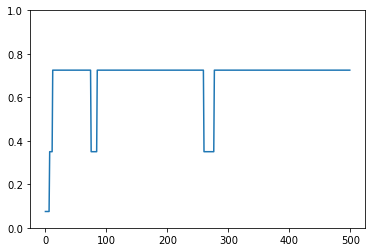

[0.375 0.4   0.625 0.65  0.675 0.7   0.725 0.925] [0.075 0.35  0.725]


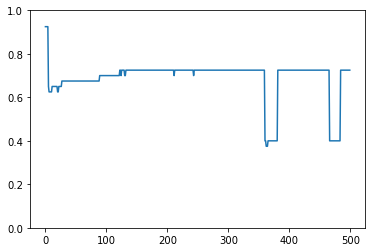

In [123]:
# plt.plot(v1v2_values[0,:])
# plt.show()

plt.plot(v1v2_values[0,3500:4000])
plt.ylim((0,1))
plt.show()

print(np.unique(v1v2_values[0,2000:2500]), np.unique(v1v2_values[0,3500:4000]))
plt.plot(v1v2_values[0,2000:2500])
plt.ylim((0,1))
plt.show()